In [ ]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import Sense, Diff3dgram
from mirtorch.alg.cg import CG
import os
import sys
from recutl import mri_coil_compress
from mirtorch.graph import tim

In [22]:
# set variables
gpu_idx = 2 # GPU index for CUDA
fname_kdata = '/home/djfrey/data/lps_fmri_20250411/gre_fatsat/gre3d.h5' # name of the GRE data file
compute_smaps = False # flag to compute the sensitivity maps
fname_smaps = os.path.join(os.path.dirname(fname_kdata), '../smaps.h5') # name of the smaps file
ncoil_comp = 16 # number of virtual coils to compress to
lam = 0.1 # regularization parameter for quadratic differencing penalty
niter = 100 # number of iterations for CG

In [23]:
# select device
if torch.cuda.is_available():
    print('CUDA is available')
    device0 = torch.device(f'cuda:{gpu_idx}')
else:
    print('CUDA is not available')
    device0 = torch.device('cpu')

CUDA is available


In [24]:
# load in the GRE data
with h5py.File(fname_kdata, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    msk = h5_file['msk'][:] # sampling mask
    fov = h5_file['seq_args/fov'][0][0] # fov (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    Nacs = int(h5_file['seq_args/Nacs'][0][0]) # 3D matrix size
    ncoil = int(h5_file['ncoil'][0][0]) # number of coils

# reshape into tensors
kdata = torch.tensor(kdata).reshape(1,ncoil,N,N,N) # 1 x C x Kz x Ky x Kx
msk = torch.tensor(msk).unsqueeze(0) # 1 x Kz x Ky x Kx

In [25]:
# compute the sensitivity maps
if compute_smaps:

    # import BART toolbox
    bart_path = os.getenv('BART_TOOLBOX_PATH')
    if bart_path:
        sys.path.append(os.path.join(bart_path, 'python'))
    else:
        raise EnvironmentError("BART_TOOLBOX_PATH environment variable is not set")
    from bart import bart

    # calculate the coil sensitivity maps
    smaps = bart(1, f'ecalib -b0 -m1 -r{Nacs}', kdata.squeeze(0).permute(3,2,1,0).numpy()) # X x Y x Z x C
    smaps = torch.tensor(smaps).permute(3,2,1,0) # C x Z x Y x X

    # save to h5 file in the same directory as fname
    with h5py.File(fname_smaps, 'w') as smaps_h5:
        smaps_h5.create_dataset('real', data=smaps.real.numpy())
        smaps_h5.create_dataset('imag', data=smaps.imag.numpy())

In [26]:
# load in the sensitivity maps
with h5py.File(fname_smaps, 'r') as h5_file:
    smaps = torch.tensor(h5_file['/real'][:] + 1j * h5_file['/imag'][:]).unsqueeze(0).to(kdata) # kspace data

In [27]:
# permute the data to the correct dimensions
kdata = kdata.permute(0,1,4,3,2) # 1 x C x Kx x Ky x Kz
msk = msk.permute(0,3,2,1) # 1 x Kx x Ky x Kz
smaps = smaps.permute(0,1,4,3,2) # 1 x C x X x Y x Z

In [28]:
# coil compress the data
kdata_comp,Vr = mri_coil_compress(kdata, ncoil=ncoil_comp)

# coil compress the sensitivity maps
smaps_comp,_ = mri_coil_compress(smaps, Vr=Vr)

In [29]:
# create the linear operator for the 3D sense reconstruction
A = Sense(
    masks=msk.to(device0), # sampling mask
    smaps=smaps_comp.to(device0) # compressed sensitivity maps
)

# add quadratic differencing regularization to the gram matrix for Tikhonov regularization
THT = Diff3dgram(A.size_in)
AHA_tikh = A.H*A + lam*THT

# set up data
y = kdata_comp
AHy = (A.H*(y.to(device0))).cpu()

# set up the CG solver
solv = CG(AHA_tikh, max_iter=niter)

# remove the linear operators from GPU memory to save space
del A
del AHA_tikh

# clear the GPU cache to free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [30]:
# intiialize to zeros
x0 = torch.zeros(1,1,N,N,N).to(kdata)

# run the CG solver
x = solv.run(x0.to(device0), AHy.to(device0))

# move the variables back to CPU
x = x.cpu()

# clear the GPU cache to free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

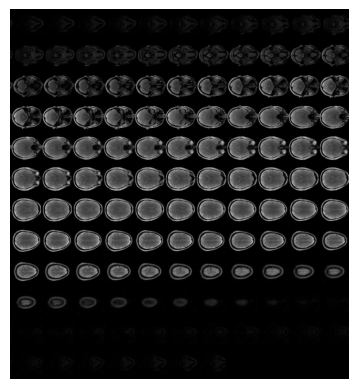

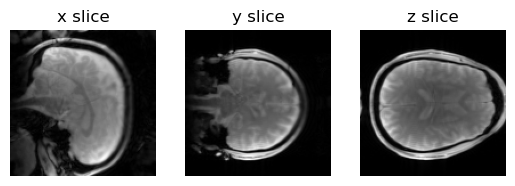

In [ ]:
# show the data
tim(x,viewtype='montage')
tim(x,viewtype='mid3')